# EST

Train tactile data using Event Spike Tensor framework. This code has some modifications:
1. The classifier is changed from RESNET to simpler model since tactile is not that big
2. We map event data into $5\times7\times9$ tensor
3. We use pre-trained kernels given in the repo

In [68]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from IPython.display import HTML
from sklearn.metrics import confusion_matrix
import seaborn as sn
import torch
import numpy as np
from utils.models2 import QuantizationLayer
import torch.nn as nn
from utils.loader import Loader
from utils.models2 import Classifier
from utils.loss import cross_entropy_loss_and_accuracy

In [69]:
# Dataset definition
class RawDataset(Dataset):
    def __init__(self, datasetPath, sampleFile, modals=0):
        self.path = datasetPath 
        self.samples = np.loadtxt(sampleFile, dtype=str)
        

    def __getitem__(self, index):
        inputIndex  = self.samples[index, 0]
        classLabel  = int(self.samples[index, 1])
        #desiredClass = torch.zeros((20, 1, 1, 1))
        #desiredClass[classLabel,...] = 1
        inputSpikes_tact_left = torch.FloatTensor( np.load(self.path + inputIndex + '_left.npy') )
        inputSpikes_tact_right = torch.FloatTensor( np.load(self.path + inputIndex+ '_right.npy') )    
        return inputSpikes_tact_left, inputSpikes_tact_right, classLabel
        
    def __len__(self):
        return self.samples.shape[0]

In [3]:
device = torch.device('cuda:1')

In [59]:
class FLAGS3():
    def __init__(self):
        self.batch_size = 4
        self.data_dir = '/home/tasbolat/some_python_examples/data_VT_SNN/'
        self.sample_file = 1
        self.lr = 1e-4
        self.epochs = 40
args = FLAGS3()

class FLAGS():
    def __init__(self):
        self.batch_size = args.batch_size
        self.pin_memory =True
        self.num_workers = 1
        self.device = device
flags = FLAGS()

In [60]:
# Dataset and dataLoader instances.
split_list = ['80_20_1','80_20_2','80_20_3','80_20_4','80_20_5']

    
trainingSet = RawDataset(datasetPath = args.data_dir + 'tact_rpg_data/', 
                        sampleFile = args.data_dir + "/train_" + split_list[args.sample_file] + ".txt")
train_loader = Loader(trainingSet, flags, device=device)    

testingSet = RawDataset(datasetPath = args.data_dir + 'tact_rpg_data/', 
                        sampleFile  = args.data_dir + "/test_" + split_list[args.sample_file] + ".txt")
test_loader = Loader(testingSet, flags, device=device)
in1, _, _  = trainingSet[7]
in1.shape

torch.Size([13517, 4])

In [61]:
13548/78

173.69230769230768

In [62]:
voxel_dimension=(5,7,9)
mlp_layers=[1, 30, 30, 1]
activation=nn.LeakyReLU(negative_slope=0.1)

In [63]:
model = Classifier(voxel_dimension=voxel_dimension, 
                     mlp_layers=mlp_layers, 
                     activation=activation, num_classes=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5)

In [70]:
args.lr

0.0001

In [64]:
len(trainingSet)

240

In [65]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

In [66]:
criterion = torch.nn.CrossEntropyLoss()

In [67]:
for epoch in range(1, args.epochs+1):
    sum_loss = 0
    correct = 0
    model.train()
    for events1, events2, labels in train_loader:
        optimizer.zero_grad()
        out, vox1, vox2 = model.forward(events1, events2)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(out.data, 1)
        correct += (predicted == labels).sum().item()  
        sum_loss += loss.item()
    if epoch % 10 == 9:
        lr_scheduler.step()
    training_loss = sum_loss/ len(trainingSet)
    training_accuracy = correct / len(trainingSet)
    train_loss.append(training_loss)
    train_acc.append(training_accuracy)
    
    
    model.eval()
    correct = 0
    sum_loss = 0
    model.eval()
    with torch.no_grad():
        for events1, events2, labels in test_loader:       
            out, vox1, vox2 = model.forward(events1, events2)
            loss = criterion(out, labels)
            _, predicted = torch.max(out.data, 1)
            correct += (predicted == labels).sum().item()        
            sum_loss += loss.item()
    validation_loss = sum_loss / len(testingSet)
    validation_accuracy = correct / len(testingSet)
    test_loss.append(validation_loss)
    test_acc.append(validation_accuracy)
    
    if epoch%10==0:
        print('Train loss:', training_loss, 'Test loss:', validation_loss)
        print('Train accuracy:', training_accuracy, 'Test accuracy:', validation_accuracy)

Train loss: 0.067208311567083 Test loss: 0.1843026931087176
Train accuracy: 0.9625 Test accuracy: 0.7333333333333333
Train loss: 0.020188155692691605 Test loss: 0.1589604618648688
Train accuracy: 0.9958333333333333 Test accuracy: 0.8166666666666667
Train loss: 0.011210189092283447 Test loss: 0.16491306958099206
Train accuracy: 1.0 Test accuracy: 0.8166666666666667
Train loss: 0.00814403973830243 Test loss: 0.16773160059625905
Train accuracy: 1.0 Test accuracy: 0.8166666666666667
Train loss: 0.0068787368518921236 Test loss: 0.17073317194978396
Train accuracy: 1.0 Test accuracy: 0.8


KeyboardInterrupt: 

In [58]:
count = 0
for p in model.parameters():
    print(count)
    count +=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


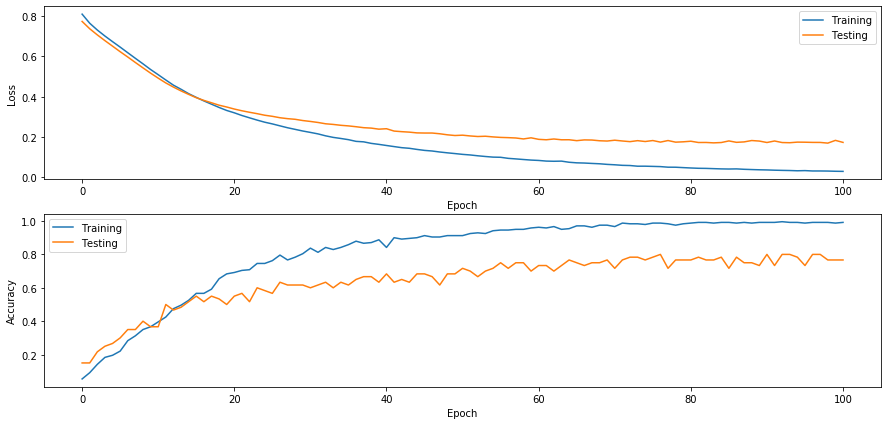

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=(15,7))

ax[0].plot(train_loss, label='Training')
ax[0].plot(test_loss, label='Testing')

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training')
ax[1].plot(test_acc, label='Testing')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
#lt.savefig(ref_name + "_" + str(k) + "_stat_plot.png")
plt.show()

In [ ]:
#torch.save(model.state_dict(), 'rpg_baseline' + ".pt")